In [67]:
import pandas as pd
import numpy as np
from datetime import datetime
import os
import math

import yfinance as yf

from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, r2_score, mean_squared_error, root_mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import mean_squared_error

import pickle

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import Infosys data
infy_data = yf.Ticker("GC=F")
infy_df = infy_data.history(period="max")

In [3]:
infy_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-08-30 00:00:00-04:00,273.899994,273.899994,273.899994,273.899994,0,0.0,0.0
2000-08-31 00:00:00-04:00,274.799988,278.299988,274.799988,278.299988,0,0.0,0.0
2000-09-01 00:00:00-04:00,277.000000,277.000000,277.000000,277.000000,0,0.0,0.0
2000-09-05 00:00:00-04:00,275.799988,275.799988,275.799988,275.799988,2,0.0,0.0
2000-09-06 00:00:00-04:00,274.200012,274.200012,274.200012,274.200012,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-04-17 00:00:00-04:00,2384.199951,2391.399902,2369.300049,2371.699951,37,0.0,0.0
2024-04-18 00:00:00-04:00,2368.399902,2384.399902,2368.399902,2382.300049,128,0.0,0.0
2024-04-19 00:00:00-04:00,2379.300049,2399.800049,2377.300049,2398.399902,160,0.0,0.0


In [4]:
# removing dividends and stock splits columns
infy_df.drop(columns=["Dividends", "Stock Splits"])

# removing last 30 days data
# df = infy_df[infy_df.index < infy_df.index[-1] - pd.Timedelta(30, 'D')]

,Open,High,Low,Close,Volume
Date,,,,,
2000-08-30 00:00:00-04:00,273.899994,273.899994,273.899994,273.899994,0
2000-08-31 00:00:00-04:00,274.799988,278.299988,274.799988,278.299988,0
2000-09-01 00:00:00-04:00,277.000000,277.000000,277.000000,277.000000,0
2000-09-05 00:00:00-04:00,275.799988,275.799988,275.799988,275.799988,2
2000-09-06 00:00:00-04:00,274.200012,274.200012,274.200012,274.200012,0
...,...,...,...,...,...
2024-04-17 00:00:00-04:00,2384.199951,2391.399902,2369.300049,2371.699951,37
2024-04-18 00:00:00-04:00,2368.399902,2384.399902,2368.399902,2382.300049,128
2024-04-19 00:00:00-04:00,2379.300049,2399.800049,2377.300049,2398.399902,160


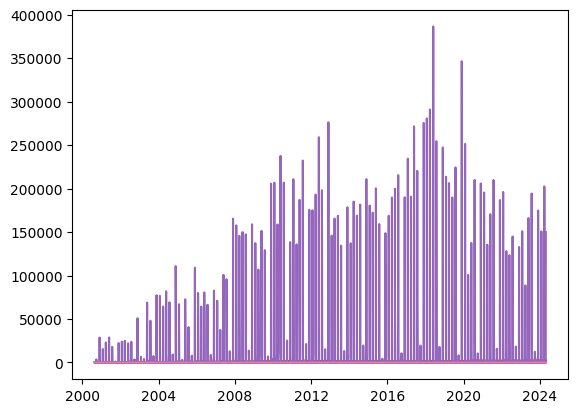

In [5]:
# plotting the stock
plt.plot(infy_df)

In [6]:
close_data_infy = infy_df["Close"]

close_data_infy

Date
2000-08-30 00:00:00-04:00     273.899994
2000-08-31 00:00:00-04:00     278.299988
2000-09-01 00:00:00-04:00     277.000000
2000-09-05 00:00:00-04:00     275.799988
2000-09-06 00:00:00-04:00     274.200012
                                ...     
2024-04-17 00:00:00-04:00    2371.699951
2024-04-18 00:00:00-04:00    2382.300049
2024-04-19 00:00:00-04:00    2398.399902
2024-04-22 00:00:00-04:00    2332.199951
2024-04-23 00:00:00-04:00    2324.500000
Name: Close, Length: 5933, dtype: float64

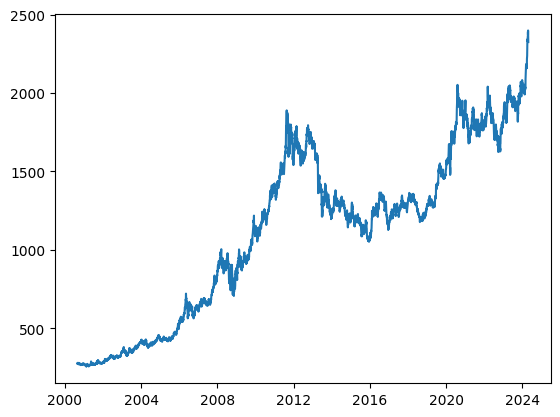

In [7]:
# plotting the price of stock on closing time
plt.plot(close_data_infy)

In [8]:
# real-valued data to discreet-valued data
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(np.array(close_data_infy).reshape(-1, 1))

In [9]:
df

array([[0.00877152],
       [0.01082442],
       [0.01021789],
       ...,
       [1.        ],
       [0.96911307],
       [0.9655205 ]])

In [10]:
# dividing data into training and testing sets
training_size = int(len(df)*0.7)
testing_size = int(len(df)) - training_size

print(f"Training size: {training_size} and testing size: {testing_size}")

Training size: 4153 and testing size: 1780


In [11]:
training_data, testing_data = df[0:training_size:], df[training_size:len(df):]

In [12]:
training_data

array([[0.00877152],
       [0.01082442],
       [0.01021789],
       ...,
       [0.4627444 ],
       [0.4633509 ],
       [0.46671024]])

In [13]:
testing_data

array([[0.4666636 ],
       [0.4657771 ],
       [0.4618579 ],
       ...,
       [1.        ],
       [0.96911307],
       [0.9655205 ]])

In [14]:
print(f"Length of training set: {len(training_data)}, calculated length: {training_size}")
print(f"Length of testing set: {len(testing_data)}, calculated length: {testing_size}")

Length of training set: 4153, calculated length: 4153
Length of testing set: 1780, calculated length: 1780


In [15]:
# creating datasets for predictions
def create_datasets(dataset, timesteps=1):
    data_x, data_y = [], []

    for i in range(len(dataset)-timesteps):
        data = dataset[i:(timesteps+i), 0]
        data_x.append(data)
        prev_data = dataset[i+timesteps, 0]
        data_y.append(prev_data)

    return np.array(data_x), np.array(data_y)

In [16]:
train_x, train_y = create_datasets(training_data, 250)
test_x, test_y = create_datasets(testing_data, 250)

In [44]:
train_x, train_y

(array([[[0.00877152],
         [0.01082442],
         [0.01021789],
         ...,
         [0.00811832],
         [0.00816498],
         [0.008025  ]],
 
        [[0.01082442],
         [0.01021789],
         [0.009658  ],
         ...,
         [0.00816498],
         [0.008025  ],
         [0.00867821]],
 
        [[0.01021789],
         [0.009658  ],
         [0.00891149],
         ...,
         [0.008025  ],
         [0.00867821],
         [0.00947137]],
 
        ...,
 
        [[0.45191993],
         [0.45084686],
         [0.450147  ],
         ...,
         [0.45653899],
         [0.46237112],
         [0.46386418]],
 
        [[0.45084686],
         [0.450147  ],
         [0.45747213],
         ...,
         [0.46237112],
         [0.46386418],
         [0.4627444 ]],
 
        [[0.450147  ],
         [0.45747213],
         [0.45341299],
         ...,
         [0.46386418],
         [0.4627444 ],
         [0.4633509 ]]]),
 array([0.00867821, 0.00947137, 0.0090048 , ..., 0.4627

In [42]:
test_x, test_y

(array([[[0.4666636 ],
         [0.4657771 ],
         [0.4618579 ],
         ...,
         [0.49993002],
         [0.5105212 ],
         [0.5129007 ]],
 
        [[0.4657771 ],
         [0.4618579 ],
         [0.46293104],
         ...,
         [0.5105212 ],
         [0.5129007 ],
         [0.50678864]],
 
        [[0.4618579 ],
         [0.46293104],
         [0.46456403],
         ...,
         [0.5129007 ],
         [0.50678864],
         [0.49881024]],
 
        ...,
 
        [[0.80903282],
         [0.81131903],
         [0.80744647],
         ...,
         [0.99645413],
         [0.9875426 ],
         [0.99248829]],
 
        [[0.81131903],
         [0.80744647],
         [0.8094061 ],
         ...,
         [0.9875426 ],
         [0.99248829],
         [1.        ]],
 
        [[0.80744647],
         [0.8094061 ],
         [0.8094994 ],
         ...,
         [0.99248829],
         [1.        ],
         [0.96911307]]]),
 array([0.50678864, 0.49881024, 0.49815709, ..., 1.    

In [28]:
model = load_model('lstm_model.keras')

In [45]:
test_y_pred = model.predict(test_x)
train_y_pred = model.predict(train_x)

48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step
122/122 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step


In [30]:
test_y

array([0.50678864, 0.49881024, 0.49815709, ..., 1.        , 0.96911307,
       0.9655205 ])

In [31]:
test_y_pred

array([[0.5101544 ],
       [0.50426817],
       [0.49626315],
       ...,
       [0.9754574 ],
       [0.9811296 ],
       [0.945751  ]], dtype=float32)

In [47]:
y_test = scaler.fit_transform(test_y.reshape(-1, 1))
y_test_pred = scaler.fit_transform(test_y_pred.reshape(-1, 1))

In [48]:
y_train = scaler.fit_transform(train_y.reshape(-1, 1))
y_train_pred = scaler.fit_transform(train_y_pred.reshape(-1, 1))

In [49]:
y_test_binary = (y_test > 0.5).astype(int)
y_test_pred_binary = (test_y_pred > 0.5).astype(int)
y_train_binary = (y_train > 0.5).astype(int)
y_train_pred_binary = (train_y_pred > 0.5).astype(int)

In [50]:
acc_test = accuracy_score(y_test_binary, y_test_pred_binary)
acc_train = accuracy_score(y_train_binary, y_train_pred_binary)

In [51]:
(acc_test, acc_train)

(0.6679738562091503, 0.7271329746348962)

In [52]:
pres_test = precision_score(y_test_binary, y_test_pred_binary)
pres_train = precision_score(y_train_binary, y_train_pred_binary)

In [53]:
(pres_test, pres_train)

(0.5913113435237329, 1.0)

In [55]:
rec_test = recall_score(y_test_binary, y_test_pred_binary)
rec_train = recall_score(y_train_binary, y_train_pred_binary)

In [56]:
(rec_test, rec_train)

(1.0, 0.4154774972557629)

In [57]:
f1_test = f1_score(y_test_binary, y_test_pred_binary)
f1_train = f1_score(y_train_binary, y_train_pred_binary)

In [58]:
(f1_test, f1_train)

(0.7431749241658241, 0.5870492438929817)

In [90]:
mse_test = mean_squared_error(y_test_binary, y_test_pred_binary)
mse_train = mean_squared_error(y_train_binary, y_train_pred_binary)

In [95]:
(mse_test, mse_train)

(<tf.Tensor: shape=(1530,), dtype=float32, numpy=array([1., 1., 0., ..., 0., 0., 0.], dtype=float32)>,
 <tf.Tensor: shape=(3903,), dtype=float32, numpy=array([0., 0., 0., ..., 1., 1., 1.], dtype=float32)>)

In [92]:
rmse_test = root_mean_squared_error(y_test_binary, y_test_pred_binary)
rmse_train = root_mean_squared_error(y_train_binary, y_train_pred_binary)

In [93]:
(rmse_test, rmse_train)

(0.5762170977946156, 0.5223667536942831)

In [59]:
r2_test = r2_score(y_test_binary, y_test_pred_binary)
r2_train = r2_score(y_train_binary, y_train_pred_binary)

In [60]:
(r2_test, r2_train)

(-0.3301501732768577, -0.09629568871252192)

In [61]:
cm_test = confusion_matrix(y_test_binary, y_test_pred_binary)
cm_train = confusion_matrix(y_train_binary, y_train_pred_binary)

In [62]:
cm_test

array([[287, 508],
       [  0, 735]], dtype=int64)

In [63]:
cm_train

array([[2081,    0],
       [1065,  757]], dtype=int64)

In [64]:
def plotCM(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

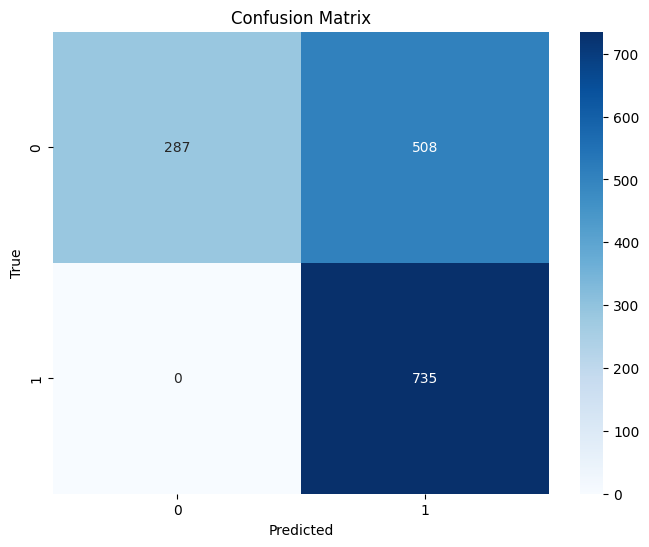

In [65]:
plotCM(cm_test)

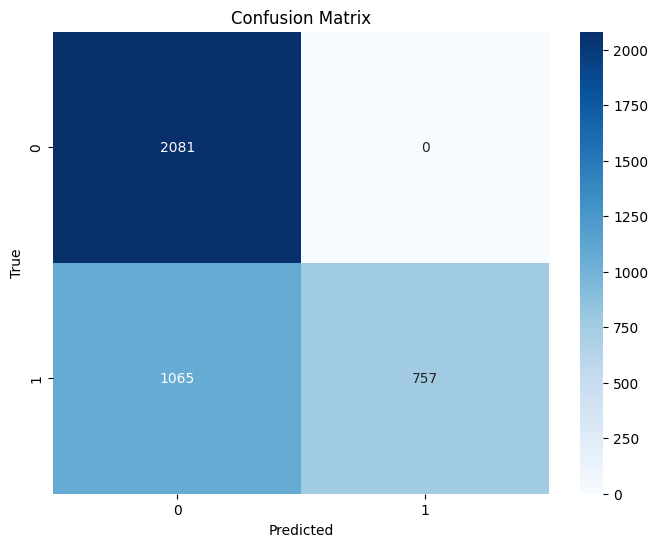

In [66]:
plotCM(cm_train)

In [19]:
train_x.shape, train_y.shape

((3903, 250), (3903,))

In [20]:
# reshape data into (batch size, timesteps, features)
train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], 1)
test_x = test_x.reshape(test_x.shape[0], test_x.shape[1], 1)

In [21]:
train_x

array([[[0.00877152],
        [0.01082442],
        [0.01021789],
        ...,
        [0.00811832],
        [0.00816498],
        [0.008025  ]],

       [[0.01082442],
        [0.01021789],
        [0.009658  ],
        ...,
        [0.00816498],
        [0.008025  ],
        [0.00867821]],

       [[0.01021789],
        [0.009658  ],
        [0.00891149],
        ...,
        [0.008025  ],
        [0.00867821],
        [0.00947137]],

       ...,

       [[0.45191993],
        [0.45084686],
        [0.450147  ],
        ...,
        [0.45653899],
        [0.46237112],
        [0.46386418]],

       [[0.45084686],
        [0.450147  ],
        [0.45747213],
        ...,
        [0.46237112],
        [0.46386418],
        [0.4627444 ]],

       [[0.450147  ],
        [0.45747213],
        [0.45341299],
        ...,
        [0.46386418],
        [0.4627444 ],
        [0.4633509 ]]])

In [22]:
# building LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

c:\Users\Mehul\CODES\StockPrediction-Minor\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# train model
model.compile(optimizer="adam", loss="mean_squared_error", metrics=["accuracy"])

In [25]:
model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 19s 260ms/step - accuracy: 0.0000e+00 - loss: 0.0294 - val_accuracy: 6.5359e-04 - val_loss: 0.0015
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 15s 254ms/step - accuracy: 0.0000e+00 - loss: 3.4460e-04 - val_accuracy: 6.5359e-04 - val_loss: 0.0010
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 16s 269ms/step - accuracy: 0.0000e+00 - loss: 3.0344e-04 - val_accuracy: 6.5359e-04 - val_loss: 7.9599e-04
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 16s 269ms/step - accuracy: 0.0000e+00 - loss: 2.9566e-04 - val_accuracy: 6.5359e-04 - val_loss: 6.5121e-04
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 16s 266ms/step - accuracy: 0.0000e+00 - loss: 2.9520e-04 - val_accuracy: 6.5359e-04 - val_loss: 6.7990e-04
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 17s 275ms/step - accuracy: 0.0000e+00 - loss: 2.6462e-04 - val_accuracy: 6.5359e-04 - val_loss: 5.1599e-04
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 19s 316ms/step - accuracy: 0.0000e+00 - loss: 2.7671e-04 - val_accuracy: 6.5359e-04 - val_loss: 7

In [26]:
with open('lstm_model.pkl', 'wb') as file:
    pickle.dump(model, file)

AttributeError: Can't pickle local object 'Layer._initializer_tracker.<locals>.<lambda>'

In [27]:
model.save('lstm_model.keras')

In [96]:
# predicting data
train_predict = model.predict(train_x)
test_predict = model.predict(test_x)

122/122 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step


In [97]:
y_pred_classes = (test_predict > 0.5).astype(int)
y_pred_classes

array([[1],
       [1],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [98]:
t = scaler.inverse_transform(test_y)

ValueError: Expected 2D array, got 1D array instead:
array=[0.50678864 0.49881024 0.49815709 ... 1.         0.96911307 0.9655205 ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [99]:
# Calculate precision and recall
precision = precision_score(t, y_pred_classes)
recall = recall_score(t, y_pred_classes)
f1 = (precision*recall)/(precision+recall)
f1 = 2*f1

NameError: name 't' is not defined

In [35]:
precision

0.0

In [36]:
recall

0.0

In [39]:
f1

nan

In [100]:
train_predict

array([[0.00755472],
       [0.00756822],
       [0.00792377],
       ...,
       [0.46132436],
       [0.46038708],
       [0.46069983]], dtype=float32)

In [29]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [30]:
train_predict

array([[7.1074185],
       [6.8290524],
       [6.981919 ],
       ...,
       [6.6089425],
       [6.649187 ],
       [6.695852 ]], dtype=float32)

In [35]:
mse = mean_squared_error(train_y, train_predict)
rmse = np.sqrt(mse)

print(f"mean_squared_error: {mse}")
print(f"Root mean squared error: {rmse}")

mean_squared_error: [46.818695 43.031586 45.060513 ... 40.403507 40.89111  41.55251 ]
Root mean squared error: [6.8424187 6.5598464 6.712713  ... 6.356375  6.3946157 6.4461236]


In [36]:
mse = mean_squared_error(test_y, test_predict)
rmse = np.sqrt(rmse)

print(f"mean_squared_error: {mse}")
print(f"Root mean squared error: {rmse}")

mean_squared_error: [ 35.29479   35.24796   33.783028 ... 267.5491   283.40436  283.01712 ]
Root mean squared error: [2.6158018 2.5612197 2.5908904 ... 2.5211854 2.5287578 2.5389218]


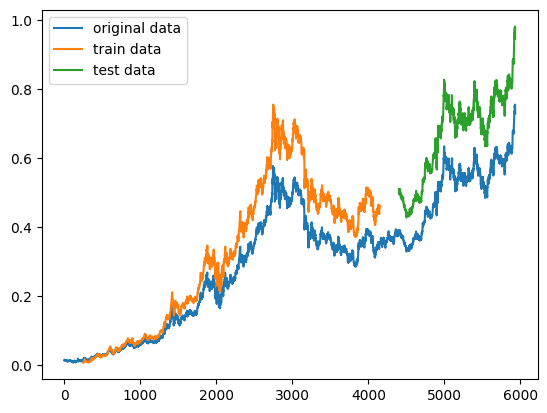

In [101]:
look_back=250
train_predict_plot = np.empty_like(df)
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
test_predict_plot = np.empty_like(df)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(look_back*2)-1:len(df)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df), label="original data")
plt.plot(train_predict_plot, label="train data")
plt.plot(test_predict_plot, label="test data")
plt.legend()
plt.show()

In [103]:
x_input = testing_data[len(testing_data)-250:].reshape(1, -1)
x_input.shape

(1, 250)

In [104]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [105]:
len(temp_input)

250

In [106]:
lst_output=[]
n_steps=250
i=0

while(i<30):
    
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.95333284]
251
1 day input [0.8094994  0.8063734  0.82079043 0.82746235 0.83651382 0.82223679
 0.82638927 0.83100827 0.82834885 0.82097701 0.82088372 0.82251672
 0.80870625 0.80511362 0.79382265 0.80418048 0.8023609  0.80124112
 0.79676206 0.78757059 0.78803716 0.7945225  0.79727528 0.80385391
 0.79190972 0.7945225  0.79802178 0.78738395 0.79713528 0.79648207
 0.79326278 0.78827045 0.79326278 0.79442921 0.79470914 0.78402467
 0.78299824 0.77338685 0.77637291 0.77851912 0.77399341 0.77320026
 0.77175385 0.77730605 0.77758598 0.77660619 0.77152056 0.77968554
 0.77912568 0.7820651  0.79368265 0.79508236 0.79550229 0.79190972
 0.80348063 0.80362062 0.7993282  0.79746192 0.79559564 0.79643543
 0.79960813 0.78864373 0.79564228 0.80035463 0.78645081 0.78491116
 0.78239167 0.7859376  0.78309153 0.77870576 0.77464662 0.77418005
 0.77348019 0.77240706 0.76862785 0.76564179 0.76004295 0.76097609
 0.76433543 0.76578178 0.77609298 0.77595298 0.77264034 0.77581304
 0.78449124 0.78813051 0.78528439

In [107]:
day_new=np.arange(1,251)
day_pred=np.arange(251, 281)

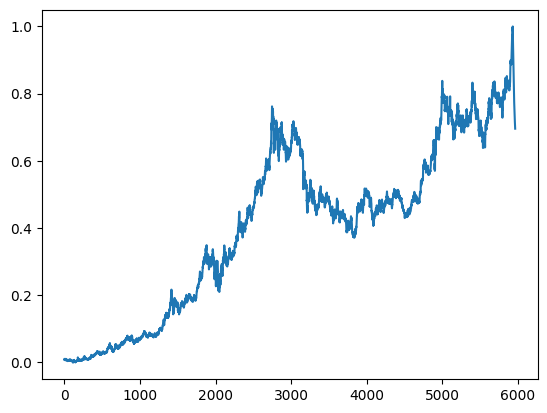

In [108]:
df2=df.tolist()
df2.extend(lst_output)
plt.plot(df2)

In [52]:
loaded_model = load_model('lstm_model.keras')

In [69]:
data2 = yf.download('AAPL', start='2021-02-01', end='2023-12-31')

[*********************100%%**********************]  1 of 1 completed


In [70]:
prediction = loaded_model.predict(data2["Close"])

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


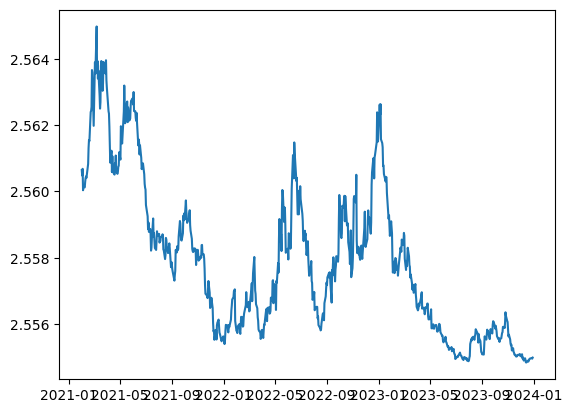

In [71]:
plt.plot(data2.index, prediction)

In [3]:
model = load_model('lstm_model.keras')

In [4]:
data = yf.download("INFY")

[*********************100%%**********************]  1 of 1 completed


In [5]:
data = data['Close']
data

Date
1999-03-11     0.732422
1999-03-12     0.728516
1999-03-15     0.662109
1999-03-16     0.656250
1999-03-17     0.660156
                ...    
2024-04-15    17.270000
2024-04-16    17.049999
2024-04-17    16.950001
2024-04-18    16.510000
2024-04-19    16.809999
Name: Close, Length: 6319, dtype: float64

In [12]:
data[::30]

Date
1999-03-11     0.732422
1999-04-23     0.666016
1999-06-07     0.808594
1999-07-20     1.339844
1999-08-31     1.549805
                ...    
2023-10-02    17.180000
2023-11-13    16.549999
2023-12-27    18.600000
2024-02-09    20.100000
2024-03-25    17.629999
Name: Close, Length: 211, dtype: float64

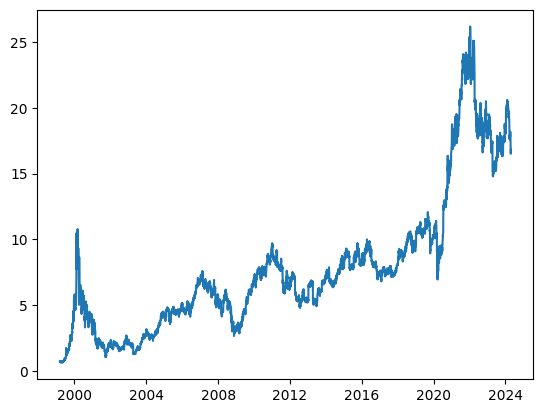

In [8]:
plt.plot(data)

In [9]:
pred = model.predict(data[::-30])

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
